In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit.circuit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.providers.aer.backends import AerSimulator
from qiskit.visualization import plot_histogram
from qpie import QPIE
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize

In [2]:
statevec_sim = Aer.get_backend("statevector_simulator")
backend = AerSimulator()
shots = 8192

In [3]:
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

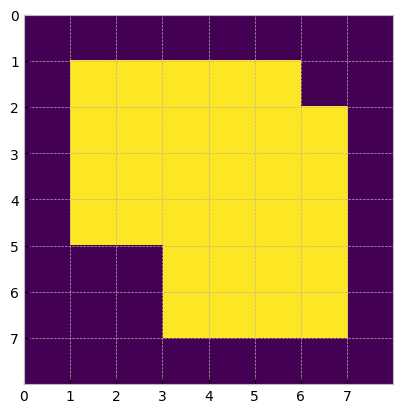

In [4]:
plt.style.use("bmh")
plt.xticks(range(image.shape[0]))
plt.yticks(range(image.shape[1]))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0])

In [5]:
qpie_class = QPIE()

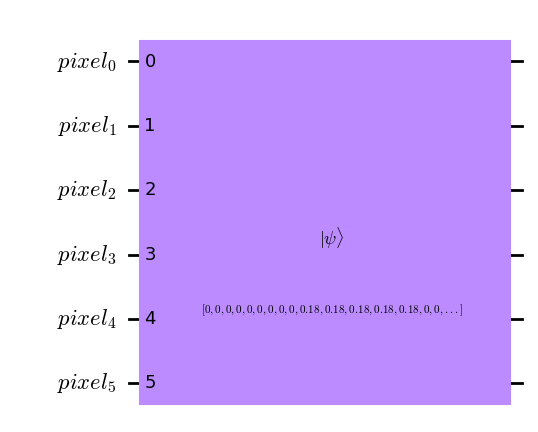

In [6]:
qc = qpie_class.image_quantum_circuit(image=image)
qc.draw(output="mpl") 

In [7]:
statevec = statevec_sim.run(qc).result().get_statevector()

In [8]:
np_statevec = np.real(statevec)

In [9]:
np_statevec.reshape(8,8)

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       ],
       [0.       , 0.1796053, 0.1796053, 0.1796053, 0.1796053, 0.1796053,
        0.       , 0.       ],
       [0.       , 0.1796053, 0.1796053, 0.1796053, 0.1796053, 0.1796053,
        0.1796053, 0.       ],
       [0.       , 0.1796053, 0.1796053, 0.1796053, 0.1796053, 0.1796053,
        0.1796053, 0.       ],
       [0.       , 0.1796053, 0.1796053, 0.1796053, 0.1796053, 0.1796053,
        0.1796053, 0.       ],
       [0.       , 0.       , 0.       , 0.1796053, 0.1796053, 0.1796053,
        0.1796053, 0.       ],
       [0.       , 0.       , 0.       , 0.1796053, 0.1796053, 0.1796053,
        0.1796053, 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       ]])

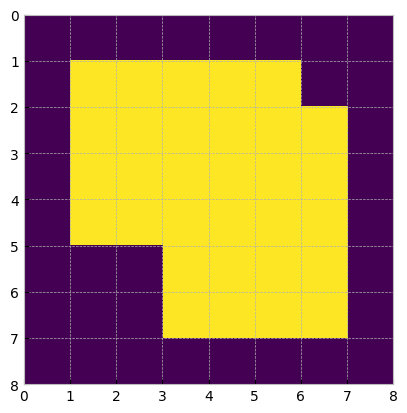

In [10]:
plt.imshow(np_statevec.reshape(8,8), extent=[0, image.shape[0], image.shape[1], 0])

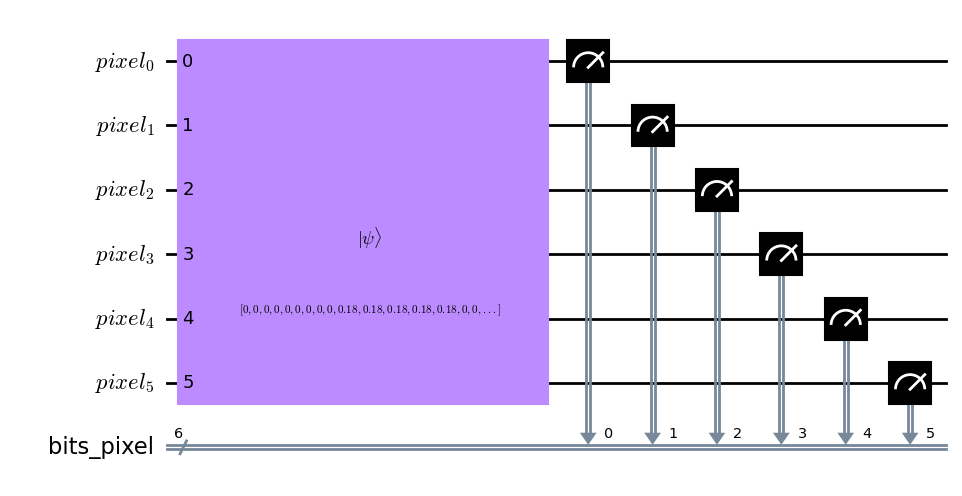

In [11]:
qc = qpie_class.image_quantum_circuit(image=image, measurements=True)
qc.draw(output="mpl") 

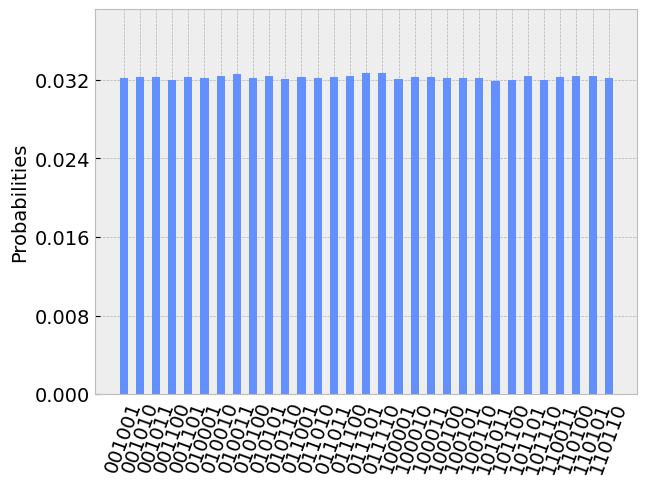

In [12]:
counts = backend.run(qc, shots=2**20).result().get_counts()
plot_histogram(counts, bar_labels=False)

In [13]:
astro_pic = data.astronaut()

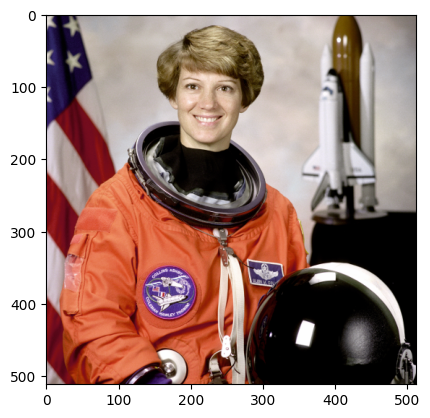

In [14]:
plt.style.use("default")
plt.imshow(astro_pic)

In [15]:
gray_resized_astro_pic = resize(rgb2gray(astro_pic), (8,8))

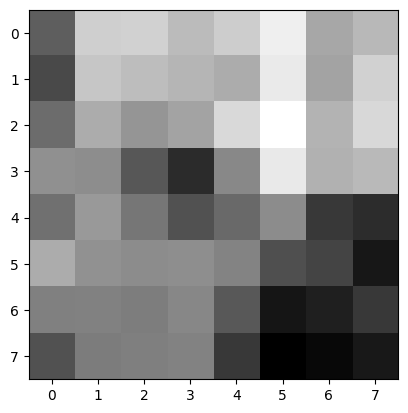

In [16]:
plt.imshow(gray_resized_astro_pic, cmap="gray")

In [17]:
qc = qpie_class.image_quantum_circuit(image=gray_resized_astro_pic)

In [18]:
statevec = statevec_sim.run(qc).result().get_statevector()
img = np.real(statevec).reshape(8,8)

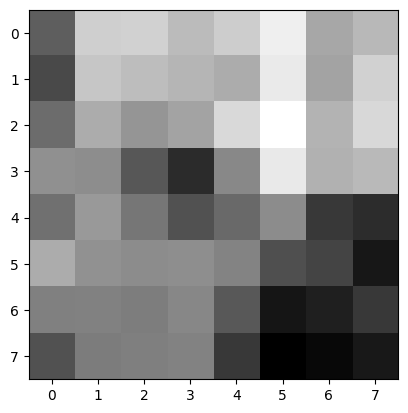

In [19]:
plt.imshow(img, cmap="gray")

In [20]:
plt.style.use("bmh")

In [21]:
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

In [22]:
D2n_1 = np.roll(np.identity(2**7), 1, axis=1)

In [23]:
D2n_1

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [24]:
qc_h = QuantumCircuit(7)

qc_h.initialize(qpie_class._amplitude_encode(image=image), range(1,7))
qc_h.h(0)
qc_h.unitary(D2n_1, range(7))
qc_h.h(0)

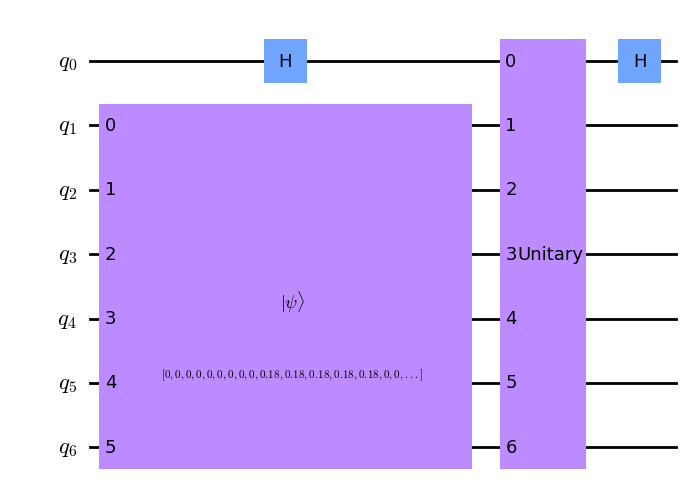

In [25]:
qc_h.draw("mpl")

In [26]:
statevec_h = statevec_sim.run(qc_h).result().get_statevector()
edge_scan_h = np.abs(np.array([1 if threshold(statevec_h[2*i+1].real) else 0 for i in range(2**6)])).reshape(8,8)

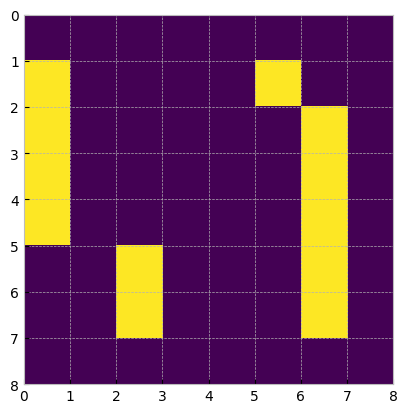

In [27]:
plt.imshow(edge_scan_h, extent=[0, image.shape[0], image.shape[1], 0])

In [28]:
qc_v = QuantumCircuit(7)

qc_v.initialize(qpie_class._amplitude_encode(image=image.T), range(1,7))
qc_v.h(0)
qc_v.unitary(D2n_1, range(7))
qc_v.h(0)

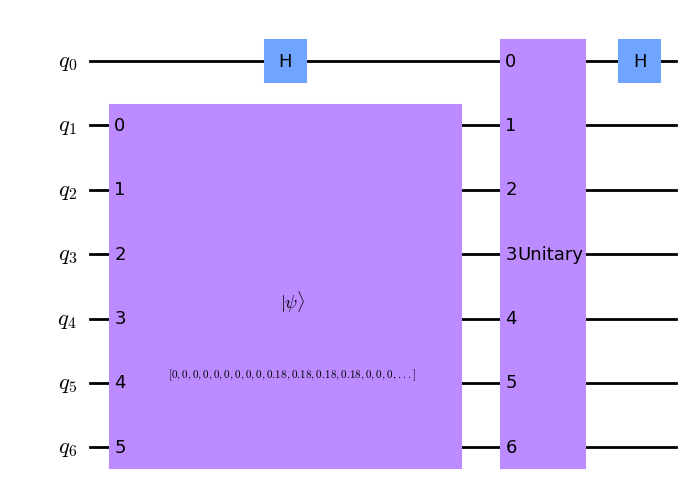

In [29]:
qc_v.draw("mpl")

In [30]:
statevec_v = statevec_sim.run(qc_v).result().get_statevector()
edge_scan_v = np.abs(np.array([1 if threshold(statevec_v[2*i+1].real) else 0 for i in range(2**6)])).reshape(8,8).T

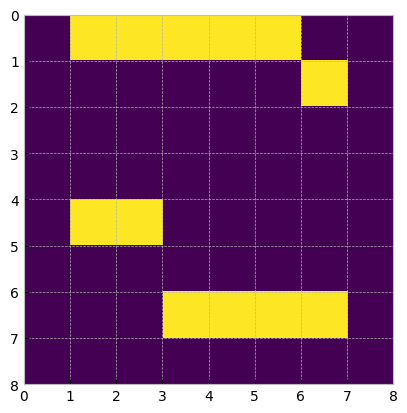

In [31]:
plt.imshow(edge_scan_v, extent=[0, image.shape[0], image.shape[1], 0])

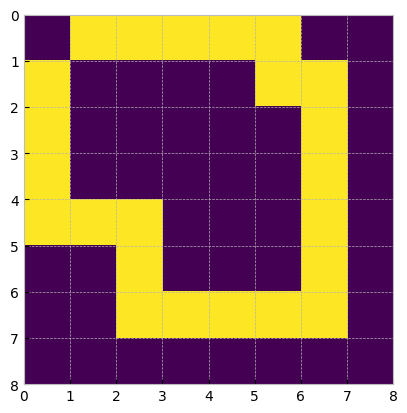

In [32]:
edge_scan_sim = edge_scan_h | edge_scan_v

plt.imshow(edge_scan_sim, extent=[0, image.shape[0], image.shape[1], 0])